# HVDC Transmission Analysis

This code script contains a Comparative Analysis of High Voltage Direct Current (HVDC) Transmission Projects by Project Location

---------------------------------------------

Original Research Content Created by the Climate Innovation Initiative at Environmental Defense Fund

In [112]:
#Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as stats 
from scipy.stats import fisher_exact

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings('default')

In [2]:
# Load in Transmission (Tx) dataset (.xlsx)
Tx = pd.read_excel(r'C:data/hvdc_projects_EDF_2023.xlsx')

In [3]:
Tx.head()

,project,tag,type,timeline,service_year,construction_year,final_permit_year,initial_permit_year,proposal_year,initial_dev_year,...,cost_million,cost/unit,PPI_factor,power_rating_MW,purpose,voltage_rating_kV,cable_loc,website,other useful links,Unnamed: 26
0,Champlain Hudson Power Express,CHPE,HVDC,Planned,2026,2022,2022,2010,2008.0,2008.0,...,6000,16.129032,1.000000,1250,Hydro,320,UW/UG,https://chpexpress.com/,NaN,NaN
1,SOO Green,SOO Green,HVDC,Planned,2027,tbd,2023,2020,2019.0,2015.0,...,2500,7.142857,1.000000,2100,VRE,525,UG/UW,https://soogreen.com/about/,https://www.renewableenergyworld.com/policy-re...,NaN
2,Cross Sound Cable,Cross Sound Cable,HVDC,Operation,2004,2002,2001,2000,1999.0,1999.0,...,125,5.208333,1.870106,330,Connection; Reliability,150,UW/UG,https://library.e.abb.com/public/4664a655cb2a7...,https://www.technologyreview.com/2005/04/01/23...,NaN
3,Hudson Transmission,Hudson Transmission,HVDC,Operation,2013,2011,2010,2006,2005.0,2005.0,...,850,113.333333,1.385129,660,Connection; Reliability,345,UW/UG,https://hudsonproject.com/project/,NaN,NaN
4,New England Clean Power Link,NECPL,HVDC,Cancelled,2017,NaN,2017,2013,2013.0,2010.0,...,1600,10.666667,1.343373,1000,Hydro,320,UW/UG,http://www.necplink.com/,https://vermontbiz.com/news/2023/february/16/s...,NaN


### Calculate Variables and Generate DataFrames

In [4]:
#Generate variables
tx = Tx.rename(columns={"service_year": "SY","construction_year": "CY",
                       "final_permit_year": "FPY","initial_permit_year": "IPY",
                        "proposal_year":'PY',"initial_dev_year":"IDY"})

#drop old or never developed projects not part of analysis
old_tags = ['Square Butte', 'Pacific Intertie','Intermountain Power', 'Quebec-New England','Zephyr Power', 'CU',\
           'BW1','ASWS1']#'Rock Island'

tx2 = tx.copy()
tx = tx[~tx['tag'].isin(old_tags)]




In [5]:
# set up stages for each projects to quanity the timeline for the project from proposal to in-service.
stages = ['SY','CY','FPY','IPY','PY','IDY','cost_million', 'power_rating_MW']
tx[stages] = tx[stages].applymap(lambda x: np.nan if x=='tbd' else x)

pd.options.display.max_rows = 100


In [229]:
#Generate relevant variables
tx['stage1'] = abs(tx.PY - tx.IPY) #inital development year - initial permit year
tx['stage2']= abs(tx.FPY - tx.IPY)  #inital permit year - final permit year
tx['stage3'] = abs(tx.FPY - tx.CY)  #final permit year - construction year
tx['stage4'] = abs(tx.SY - tx.CY)  #construction year year - service/final year
tx['overall']= abs(tx.SY - tx.IDY)  # overall inital development year - final year
tx['overall2']= abs(tx.SY - tx.PY)  # overall proposal year - final year
tx['ptime']= abs(tx.SY - tx.IPY)  # inital permit year to service year 
tx['length_km'] = tx.length_mile * 1.60934
tx['cost_adjusted'] = tx.cost_million * tx.PPI_factor #cost adjusted to PPI inflation 2022 USD
tx['cpm'] = tx.cost_million / tx.length_mile #cost per mile
tx['cpme'] = tx.cost_million / (tx.length_mile * tx.power_rating_MW /1000) # capacity normalized cost
tx['cpmi'] = tx.cost_million*tx.PPI_factor / tx.length_mile #cost per mile adjusted to PPI inflation 2022 USD
tx['cpmei'] = tx.cost_million*tx.PPI_factor / (tx.length_mile * tx.power_rating_MW /1000) # capacity normalized cost adjusted to PPI 2022 USD

tx['cpk'] = tx.cost_million / (tx.length_mile*1.60934) #cost per km
tx['cpke'] = tx.cost_million / ((tx.length_mile * 1.60934) * tx.power_rating_MW /1000) # capacity normalized cost
tx['cpki'] = tx.cost_million*tx.PPI_factor / (tx.length_mile * 1.60934) #cost per km adjusted to PPI inflation 2022 USD
tx['cpkei'] = tx.cost_million*tx.PPI_factor / ((tx.length_mile * 1.60934) * tx.power_rating_MW /1000) # capacity normalized cost adjusted to PPI 2022 USD

In [230]:
# Generate relevant DataFrames
hvdc = tx[tx.type == 'HVDC'].reset_index()
USA = hvdc[(hvdc.country == 'USA') | (hvdc.country == 'USA/Canada')]
EU = hvdc[hvdc.continent == 'EU']

USAp = USA[(USA.timeline == 'Operation')| (USA.timeline == 'Planned')] # Planned USA Projects (ie, not suspended/cancelled)

In [231]:
# Generate Project Location Dataframes
UG = hvdc[hvdc.cable_loc.str.contains('UG')]
OH = hvdc[hvdc.cable_loc.str.startswith('OH')] 

In [232]:
# Get USA projects only
UG  = UG[((UG.country == ('USA')) | (UG.country == ('USA/Canada')))]\
    .drop(UG.index[UG.project.str.contains("Joint State")].to_list()).reset_index(drop=True) #OH = OH.drop([17,18]).reset_index(drop=True)

OH = OH[((OH.country == 'USA') | (OH.country ==('USA/Canada')))] #.drop([27,28]).reset_index(drop=True)

In [233]:
# Visualize DataFrame
UG[['tag','cpmi','cpmei', 'length_mile','power_rating_MW']]

,tag,cpmi,cpmei,length_mile,power_rating_MW
0,CHPE,16.129032,12.903226,372.0,1250.0
1,SOO Green,7.142857,3.401361,350.0,2100.0
2,Cross Sound Cable,9.740133,29.515554,24.0,330.0
3,Hudson Transmission,156.981293,237.850445,7.5,660.0
4,NECPL,14.329307,14.329307,150.0,1000.0
5,Trans Bay Cable,13.111057,32.777641,53.0,400.0
6,Neptune Cable,16.401131,24.850199,65.0,660.0
7,TSCL,18.019802,15.016502,101.0,1200.0
8,Sunrise Wind,3.930579,4.253873,121.0,924.0
9,Cascade Renewable,15.000000,13.636364,100.0,1100.0


In [234]:
import scipy.stats as stats 
from scipy.stats import fisher_exact

# Statistical test of whether subsurface makes a project less likley to fail
# Comparisons of failure likelihood were done with Fishers Exact Test, which is appropriate for small datasets with categorical 
# data (failure: yes/no; OH: 1 / UG: -1)
data_group1 = np.array([-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,1,1,1,1]) # Planned Projects
data_group2 = np.array([1,1,-1,-1,1]) #Supended or Cancelled Projects

#create a 2x2 contingency table
data_tab = [[12,10],[2,3]]

result = fisher_exact(data_tab) 
result

SignificanceResult(statistic=1.8, pvalue=0.6483091787439615)

In [235]:
# Generate Dataframes based on Project Location and Project Timeline Status (as of October 2023)

UG_live = UG[UG.timeline.isin(['Planned','Operation'])]
UG_ded = UG[UG.timeline.isin(['Cancelled','Suspended'])]
OH_live = OH[OH.timeline.isin(['Planned','Operation'])]
OH_ded = OH[OH.timeline.isin(['Cancelled','Suspended'])]


In [236]:
#Planned HVDC Projects addition to existing Tx System
planned_additions = (USAp[USAp.timeline == 'Planned'].length_km*(USAp[USAp.timeline == 'Planned'].power_rating_MW/1000)).sum()
planned_additions_ug = (UG_live.length_km*(UG_live.power_rating_MW/1000)).sum()
print("Planned HVDC Projects represent", round(planned_additions,2), "GW-kms to the Transmission System")
print()
print("Planned Underground HVDC Projects represent", round(planned_additions_ug,2), "GW-kms to the Transmission System or",\
      round((planned_additions_ug/planned_additions)*100), "% of planned additions")

Planned HVDC Projects represent 22638.03 GW-kms to the Transmission System

Planned Underground HVDC Projects represent 3647.77 GW-kms to the Transmission System or 16 % of planned additions


## Figure 4
Length versus time by project location type

Continuous Equation for OH lines is y= 0.01 x + 6.5

Continuous Equation for UG lines is y= 0.012 x + 5.61


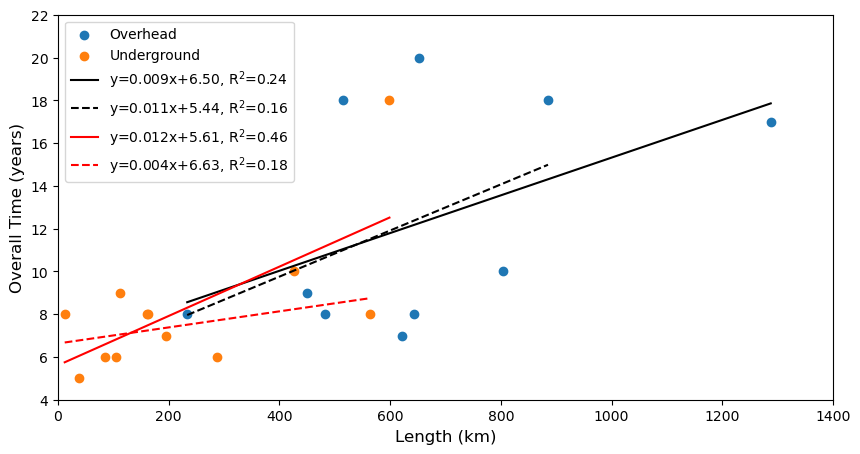

In [318]:
# Compare trends in Project length versus time by Project location (UG versus OH)

from scipy.stats import linregress

xo = OH_live.sort_values(by=['length_km'])['length_km']
yo = OH_live.sort_values(by=['length_km'])['overall2']
xo2 = OH_live[OH_live.overall2 <16].sort_values(by=['length_km'])['length_km']
yo2 = OH_live[OH_live.overall2 <16].sort_values(by=['length_km'])['overall2']

xu = UG_live.sort_values(by=['length_km'])['length_km']
yu = UG_live.sort_values(by=['length_km'])['overall2']

fig, ax = plt.subplots(figsize=(10, 5))

plt.scatter(xo, yo, label = "Overhead")
plt.scatter(xu, yu, label = "Underground")
plt.ylabel('Overall Time (years)' ,fontsize = 12)
plt.xlabel('Length (km)',fontsize = 12)

# Linear Regression to determine trend - OH
slope, intercept, r_value, p_value, std_err = linregress(xo,yo)

# Linear Regression to determine trend - OH (less than 16 year overall time)
slope2, intercept2, r_value2, p_value2, std_err2 = linregress(xo[:-1],yo[:-1])

# Linear Regression to determine trend - UG
slopeu, interceptu, r_valueu, p_valueu, std_erru = linregress(xu,yu)

# Linear Regression to determine trend - UG (without CHPE outlier)
slopeu2, interceptu2, r_valueu2, p_valueu2, std_erru2 = linregress(xu[:-1],yu[:-1])

fit_val = slope * xo + intercept
plt.plot(xo, fit_val, color= 'k', label='y={:.3f}x+{:.2f}, R$^2$={:.2f}'.format(slope,intercept,r_value**2))
fit_val2 = slope2 * xo[:-1] + intercept2
plt.plot(xo[:-1], fit_val2, 'k--', label='y={:.3f}x+{:.2f}, R$^2$={:.2f}'.format(slope2,intercept2,r_value2**2))

fit_valu = slopeu * xu+ interceptu
plt.plot(xu, fit_valu, color= 'r', label='y={:.3f}x+{:.2f}, R$^2$={:.2f}'.format(slopeu,interceptu,r_valueu**2))
fit_valu2u = slopeu2 * xu[:-1]+ interceptu2
plt.plot(xu[:-1], fit_valu2u, 'r--', label='y={:.3f}x+{:.2f}, R$^2$={:.2f}'.format(slopeu2,interceptu2,r_valueu2**2))


# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='best')
plt.ylim([4,22])
plt.xlim([0,1400])

print('Continuous Equation for OH lines is y=',round(slope,2),'x +',round(intercept,2))
print()
print('Continuous Equation for UG lines is y=',round(slopeu,3),'x +', round(interceptu,2))

In [238]:
#Examine Outliers using IQR determination
dtest = xo #yo, xu, yu
# finding the 1st quartile
q1 = np.quantile(dtest, 0.25)
 
# finding the 3rd quartile
q3 = np.quantile(dtest, 0.75)
med = np.median(dtest)
 
# finding the iqr region
iqr = q3-q1
 
# finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)
print(iqr, upper_bound, lower_bound)

275.599475 1179.8473875 77.44948750000003


In [239]:
outliers =dtest[(dtest <= lower_bound) | (dtest >= upper_bound)]
print('The following are the outliers in the boxplot:{}'.format(outliers))

The following are the outliers in the boxplot:12    1287.472
Name: length_km, dtype: float64


## Figure 2
Timeline Comparison

In [240]:
# Dependencies
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
from matplotlib.pyplot import cm
from matplotlib import pyplot
import matplotlib.patches as mpatches

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


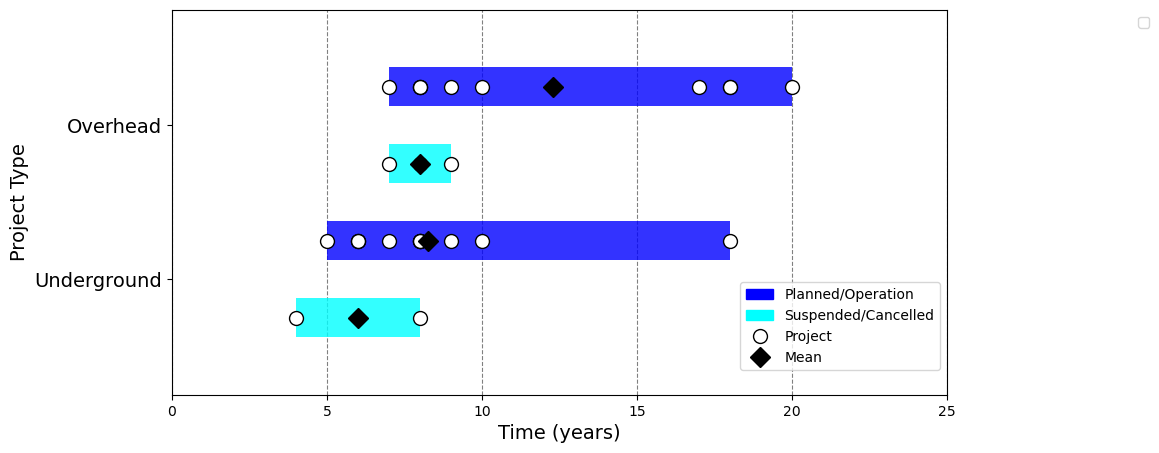

In [241]:
# Generate Figure 2
fig, ax = plt.subplots(figsize=(10, 5))

o = OH_live.overall2
oo = OH_ded.overall2
u = UG_live.overall2
uu = UG_ded.overall2

plt.barh((0.8), o.max()-o.min(), height=0.1, left=o.min(), alpha = 0.8, color = 'blue')
plt.barh((0.6), oo.max()-oo.min(), height=0.1, left=oo.min(),alpha = 0.8, color = 'cyan')
plt.barh((0.4), u.max()-u.min(), height=0.1, left=u.min(), alpha = 0.8, color = 'blue')
plt.barh((0.2),uu.max()-uu.min(), height=0.1, left=uu.min(),alpha = 0.8, color = 'cyan')


#iterate over df and plot
n = len(OH_live)
color = iter(cm.rainbow(np.linspace(0, 1, n)))
for i in range(n):
    c = next(color)
    plt.plot(OH_live.iloc[i].overall2, 0.8, linestyle="", markersize=10, 
          marker="o", color='w', markeredgecolor="k")


n = len(OH_ded)
color = iter(cm.rainbow(np.linspace(0, 1, n)))
for i in range(n):
    c = next(color)
    plt.plot(OH_ded.iloc[i].overall2, 0.6, linestyle="", markersize=10, 
          marker="o", color='w', markeredgecolor="k")
    
n = len(UG_live)
color = iter(cm.rainbow(np.linspace(0, 1, n)))
for i in range(n):
    c = next(color)
    plt.plot(UG_live.iloc[i].overall2, 0.4, linestyle="", markersize=10, 
          marker="o", color='w', markeredgecolor="k")


n = len(UG_ded)
color = iter(cm.rainbow(np.linspace(0, 1, n)))
for i in range(n):
    c = next(color)
    plt.plot(UG_ded.iloc[i].overall2, 0.2, linestyle="", markersize=10, 
          marker="o", color='w', markeredgecolor="k")

#add mean value
plt.plot(o.mean(), 0.8, linestyle="", markersize=10,\
         marker="D", color= 'k', markeredgecolor="k")
plt.plot(oo.mean(), 0.6, linestyle="", markersize=10,\
         marker="D", color= 'k', markeredgecolor="k")
plt.plot(u.mean(), 0.4, linestyle="", markersize=10,\
         marker="D", color= 'k', markeredgecolor="k")
plt.plot(uu.mean(), 0.2, linestyle="", markersize=10,\
         marker="D", color= 'k', markeredgecolor="k")


# plt.yticks([0.8,0.6, 0.4,0.2],['OH Planned/Operation', 'OH Suspended/Cancelled','UG Planned/Operation',  'UG Suspended/Cancelled'])
plt.yticks([0.7,0.3],['Overhead', 'Underground'], fontsize=14)
plt.ylabel('Project Type', fontsize=14)
plt.xlabel('Time (years)', fontsize = 14)

ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')

blue = mpatches.Patch(color='blue', label='Planned/Operation')
cyan = mpatches.Patch(color='cyan', label='Suspended/Cancelled')
white = mlines.Line2D([], [], color='w', marker='o', linestyle='None',
                            markersize=10, markeredgecolor="k",label='Project')
purple= mlines.Line2D([], [], color='k', marker='D', linestyle='None',
                            markersize=10, label='Mean')
legend = plt.legend(handles=[blue,cyan, white, purple], bbox_to_anchor=(0.65, 0.01, 0.35, 0.3))
ax.add_artist(legend)


plt.xlim(0,25)
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.27, 1))
# plt.title('Project Type')

# purple_triangle = mlines.Line2D([], [], color='k', marker='D', linestyle='None',
#                            markersize=10, label='Mean')

# plt.legend(handles=[purple_triangle],bbox_to_anchor=(1, 0.01, 0.35, 0.5))

Text(0.04, 0.5, 'Timeline')

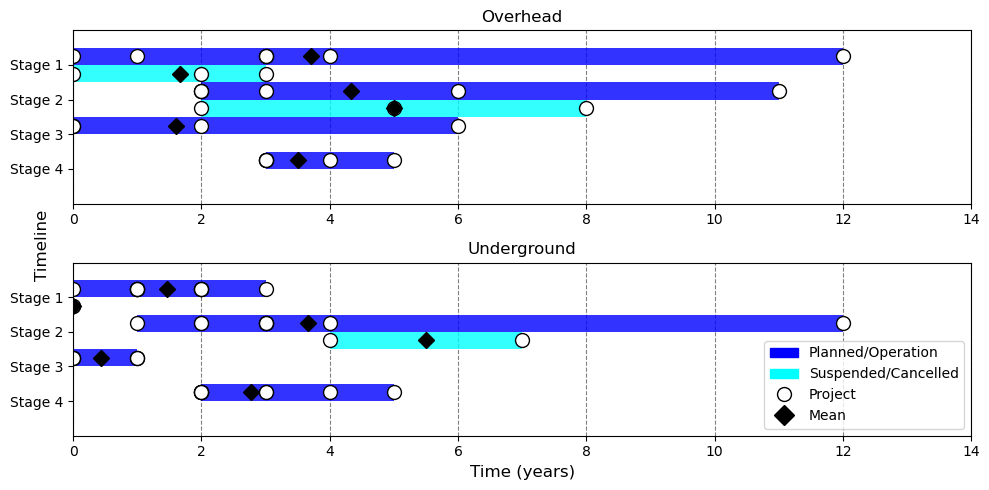

In [242]:
#Supplement Figure 2

fig, ax = plt.subplots(2,figsize=(10, 5), sharey=True)


ax[0].barh((0.85), OH_live.stage1.max()-OH_live.stage1.min(), height=0.1, left=OH_live.stage1.min(), alpha = 0.8, color = 'blue')
ax[0].barh((0.75), OH_ded.stage1.max()-OH_ded.stage1.min(), height=0.1, left=OH_ded.stage1.min(),alpha = 0.8, color = 'cyan')
ax[0].barh((0.65), OH_live.stage2.max()-OH_live.stage2.min(), height=0.1, left=OH_live.stage2.min(),alpha = 0.8, color = 'blue')
ax[0].barh((0.55), OH_ded.stage2.max()-OH_ded.stage2.min(), height=0.1, left=OH_ded.stage2.min(),alpha = 0.8, color = 'cyan')
ax[0].barh((0.45), OH_live.stage3.max()-OH_live.stage3.min(), height=0.1, left=OH_live.stage3.min(),alpha = 0.8, color = 'blue')
ax[0].barh((0.35), OH_ded.stage3.max()-OH_ded.stage3.min(), height=0.1, left=OH_ded.stage3.min(),alpha = 0.8, color = 'cyan')
ax[0].barh((0.25), OH_live.stage4.max()-OH_live.stage4.min(), height=0.1, left=OH_live.stage4.min(),alpha = 0.8, color = 'blue')
ax[0].barh((0.15), OH_ded.stage4.max()-OH_ded.stage4.min(), height=0.1, left=OH.stage4.min(),alpha = 0.8, color = 'cyan')


#iterate over df and plot
n = len(OH_live)
color = iter(cm.rainbow(np.linspace(0, 1, n)))
for i in range(n):
    c = next(color)
    ax[0].plot(OH_live.iloc[i].stage1, 0.85, linestyle="", markersize=10, 
          marker="o", color='w', markeredgecolor="k")#label= OH_live.iloc[i].tag, markeredgecolor="k")
    ax[0].plot(OH_live.iloc[i].stage2, 0.65, linestyle="", markersize=10, 
          marker="o", color='w', markeredgecolor="k")
    ax[0].plot(OH_live.iloc[i].stage3, 0.45, linestyle="", markersize=10, 
          marker="o", color='w', markeredgecolor="k")
    ax[0].plot(OH_live.iloc[i].stage4, 0.25, linestyle="", markersize=10, 
          marker="o", color='w', markeredgecolor="k")

n = len(OH_ded)
color = iter(cm.rainbow(np.linspace(0, 1, n)))
for i in range(n):
    c = next(color)
    ax[0].plot(OH_ded.iloc[i].stage1, 0.75, linestyle="", markersize=10, 
          marker="o", color='w', markeredgecolor="k") #label= OH_ded.iloc[i].tag, markeredgecolor="k")
    ax[0].plot(OH_ded.iloc[i].stage2, 0.55, linestyle="", markersize=10, 
          marker="o", color='w', markeredgecolor="k")
    ax[0].plot(OH_ded.iloc[i].stage3, 0.35, linestyle="", markersize=10, 
          marker="o", color='w', markeredgecolor="k")
    ax[0].plot(OH_ded.iloc[i].stage4, 0.15, linestyle="", markersize=10, 
          marker="o", color='w', markeredgecolor="k")

    #add mean value
ax[0].plot(OH_live.stage1.mean(), 0.85, linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k")
ax[0].plot(OH_ded.stage1.mean(), 0.75, linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k")
ax[0].plot(OH_live.stage2.mean(), 0.65, linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k")
ax[0].plot(OH_ded.stage2.mean(), 0.55, linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k")
ax[0].plot(OH_live.stage3.mean(), 0.45, linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k")
ax[0].plot(OH_ded.stage3.mean(), 0.35, linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k")
ax[0].plot(OH_live.stage4.mean(), 0.25, linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k")
ax[0].plot(OH_ded.stage4.mean(), 0.15, linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k")

ax[0].set_yticks([0.8,0.6, 0.4,0.2],['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4'])


ax[0].set_axisbelow(True)
ax[0].xaxis.grid(color='gray', linestyle='dashed')

blue = mpatches.Patch(color='blue', label='Planned/Operation')
cyan = mpatches.Patch(color='cyan', label='Suspended/Cancelled')
white = mlines.Line2D([], [], color='w', marker='o', linestyle='None',
                            markersize=10, markeredgecolor="k",label='Project')
purple= mlines.Line2D([], [], color='k', marker='D', linestyle='None',
                            markersize=10, label='Mean')
legend = plt.legend(handles=[blue,cyan, white, purple], bbox_to_anchor=(1, 0.3))


ax[0].set(xlim=(0, 14))
ax[0].set(ylim=(0, 1))
ax[0].set_title('Overhead')

ax[1].barh((0.85), UG_live.stage1.max()-UG_live.stage1.min(), height=0.1, left=UG_live.stage1.min(), alpha = 0.8, color = 'blue')
ax[1].barh((0.75), UG_ded.stage1.max()-UG_ded.stage1.min(), height=0.1, left=UG_ded.stage1.min(),alpha = 0.8, color = 'cyan')
ax[1].barh((0.65), UG_live.stage2.max()-UG_live.stage2.min(), height=0.1, left=UG_live.stage2.min(),alpha = 0.8, color = 'blue')
ax[1].barh((0.55), UG_ded.stage2.max()-UG_ded.stage2.min(), height=0.1, left=UG_ded.stage2.min(),alpha = 0.8, color = 'cyan')
ax[1].barh((0.45), UG_live.stage3.max()-UG_live.stage3.min(), height=0.1, left=UG_live.stage3.min(),alpha = 0.8, color = 'blue')
ax[1].barh((0.35), UG_ded.stage3.max()-UG_ded.stage3.min(), height=0.1, left=UG_ded.stage3.min(),alpha = 0.8, color = 'cyan')
ax[1].barh((0.25), UG_live.stage4.max()-UG_live.stage4.min(), height=0.1, left=UG_live.stage4.min(),alpha = 0.8, color = 'blue')
ax[1].barh((0.15), UG_ded.stage4.max()-UG_ded.stage4.min(), height=0.1, left=UG.stage4.min(),alpha = 0.8, color = 'cyan')


#iterate over df and plot
n = len(UG_live)
color = iter(cm.rainbow(np.linspace(0, 1, n)))
for i in range(n):
    c = next(color)
    ax[1].plot(UG_live.iloc[i].stage1, 0.85, linestyle="", markersize=10, 
          marker="o", color='w',  markeredgecolor="k")#,label= UG_live.iloc[i].tag, markeredgecolor="k")
    ax[1].plot(UG_live.iloc[i].stage2, 0.65, linestyle="", markersize=10, 
          marker="o", color='w', markeredgecolor="k")
    ax[1].plot(UG_live.iloc[i].stage3, 0.45, linestyle="", markersize=10, 
          marker="o", color='w', markeredgecolor="k")
    ax[1].plot(UG_live.iloc[i].stage4, 0.25, linestyle="", markersize=10, 
          marker="o", color='w', markeredgecolor="k")

n = len(UG_ded)
color = iter(cm.rainbow(np.linspace(0, 1, n)))
for i in range(n):
    c = next(color)
    ax[1].plot(UG_ded.iloc[i].stage1, 0.75, linestyle="", markersize=10, 
          marker="o", color='w', markeredgecolor="k")# label= UG_ded.iloc[i].tag, markeredgecolor="k")
    ax[1].plot(UG_ded.iloc[i].stage2, 0.55, linestyle="", markersize=10, 
          marker="o", color='w', markeredgecolor="k")
    ax[1].plot(UG_ded.iloc[i].stage3, 0.35, linestyle="", markersize=10, 
          marker="o", color='w', markeredgecolor="k")
    ax[1].plot(UG_ded.iloc[i].stage4, 0.15, linestyle="", markersize=10, 
          marker="o", color='w', markeredgecolor="k")

#add mean value
ax[1].plot(UG_live.stage1.mean(), 0.85, linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k")
ax[1].plot(UG_ded.stage1.mean(), 0.75, linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k")
ax[1].plot(UG_live.stage2.mean(), 0.65, linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k")
ax[1].plot(UG_ded.stage2.mean(), 0.55, linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k")
ax[1].plot(UG_live.stage3.mean(), 0.45, linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k")
ax[1].plot(UG_ded.stage3.mean(), 0.35, linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k")
ax[1].plot(UG_live.stage4.mean(), 0.25, linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k")
ax[1].plot(UG_ded.stage4.mean(), 0.15, linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k")


plt.yticks([0.8,0.6, 0.4,0.2],['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4'])

plt.xlabel('Time (years)', fontsize = 12)

ax[1].set_axisbelow(True)
ax[1].xaxis.grid(color='gray', linestyle='dashed')

blue = mpatches.Patch(color='blue', label='Planned/Operation')
cyan = mpatches.Patch(color='cyan', label='Suspended/Cancelled')
white = mlines.Line2D([], [], color='w', marker='o', linestyle='None',
                            markersize=10, markeredgecolor="k",label='Project')
purple= mlines.Line2D([], [], color='k', marker='D', linestyle='None',
                            markersize=10, label='Mean')
legend = plt.legend(handles=[blue,cyan, white, purple])#, bbox_to_anchor=(1, 0.3))

ax[1].set(xlim=(0, 14))
ax[1].set(ylim=(0, 1))
# plt.legend(bbox_to_anchor=(1, 1))
ax[1].set_title('Underground')
# fig.subplots_adjust(wspace=1)
plt.tight_layout()
fig.text(0.04, 0.5, 'Timeline', fontsize = 12, va='center', rotation='vertical')

### Investigate Projects by Location and Timeline

In [243]:
# Compare Overall time to operation
print("OH mean time:", round(OH_live.overall2.mean(),2),"years")
print("UG mean time:", round(UG_live.overall2.mean(),2),"years")

OH mean time: 12.3 years
UG mean time: 8.25 years


In [244]:
# Time comparison between Overhead and Underground (years)
(OH_live.overall2 - UG_live.overall2.mean()).mean()

4.05

In [245]:
# Compare time from initial permit year to operation
print("OH mean time:", round(OH_live.ptime.mean(),2),"years")
print("UG mean time:", round(UG_live.ptime.mean(),2),"years")

OH mean time: 10.0 years
UG mean time: 6.82 years


In [246]:
print("OH mean length:", round(OH_live.length_mile.mean(),2), "miles,", round(OH_live.length_km.mean(),2), "kilometers")
print("UG mean length:", round(UG_live.length_mile.mean(),2), "miles,", round(UG_live.length_km.mean(),2), "kilometers")

OH mean length: 408.6 miles, 657.58 kilometers
UG mean length: 142.21 miles, 228.86 kilometers


In [247]:
# Cost per unit distance - PPI Adjusted (2022 USD)
OH_cpm = OH_live.cpmi.mean()
UG_cpm = UG_live.drop([3]).cpmi.mean() # index [3] is Hudson Tx line which is an cost per unit distance outlier. 
OH_cpk = OH_live.cpki.mean()
UG_cpk = UG_live.drop([3]).cpki.mean() # index [3] is Hudson Tx line which is an cost per unit distance outlier. 


print("OH mean cost per unit distance:", round(OH_live.cpmi.mean(),2),"\u00B1", round(OH_live.cpmi.std(),2),\
      "$million/mile,", round(OH_live.cpki.mean(),2),"\u00B1", round(OH_live.cpki.std(),2), "$million/km,")
print()
print("UG mean cost per unit distance:", round(UG_live.drop([3]).cpmi.mean(),2),"\u00B1", round(UG_live.drop([3]).cpmi.std(),2),\
      "$million/mile,", round(UG_live.drop([3]).cpki.mean(),2),"\u00B1", round(UG_live.drop([3]).cpki.std(),2),"$million/km")

OH mean cost per unit distance: 6.6 ± 2.27 $million/mile, 4.1 ± 1.41 $million/km,

UG mean cost per unit distance: 12.37 ± 5.1 $million/mile, 7.69 ± 3.17 $million/km


In [248]:
# Cost comparison of Overhead versus Underground
UG_cpk/OH_cpk, UG_cpk/OH_live.cpki

(1.87478607405015,
 9     1.195602
 11    1.669720
 12    1.413520
 14    1.491926
 16    1.978927
 17    2.721025
 19    2.473659
 20    3.463123
 21    3.092074
 24    1.583142
 Name: cpki, dtype: float64)

In [249]:
# Cost per unit distance normalized to power rating 
OH_cpme = OH.cpmei.mean()
UG_cpme = UG.drop(3).cpmei.mean()

OH_cpke = OH.cpkei.mean()
UG_cpke = UG.drop(3).cpkei.mean()

print("OH mean cost per unit distance-GW:", round(OH_live.cpmei.mean(),2), u"\u00B1", round(OH_live.cpmei.std(),2),\
      "$million/mile-GW,", round(OH_live.cpkei.mean(),2),u"\u00B1", round(OH_live.cpkei.std(),2), "$million/km-GW")
print()
print("UG mean cost per unit distance-GW:", round(UG_live.drop(3).cpmei.mean(),2),  u"\u00B1", round(UG_live.drop(3).cpmei.std(),2),\
      "$million/mile-GW,", round(UG_live.drop(3).cpkei.mean(),2),  u"\u00B1", round(UG_live.drop(3).cpkei.std(),2),"$million/km-GW")

OH mean cost per unit distance-GW: 2.83 ± 2.23 $million/mile-GW, 1.76 ± 1.39 $million/km-GW

UG mean cost per unit distance-GW: 15.02 ± 10.06 $million/mile-GW, 9.34 ± 6.25 $million/km-GW


In [250]:
# power rating average
OH_pr = OH_live.power_rating_MW.mean()
UG_pr = UG_live.power_rating_MW.mean()

print("OH mean capacity:", round(OH_pr,2),"MW")
print("UG mean capacity:", round(UG_pr,2),"MW")

OH mean capacity: 2855.56 MW
UG mean capacity: 1031.17 MW


In [251]:
#Statistical test comparing overall length of time to completion for OH vs. Subsurface 
# Use Willcoxon rank sum test 
# null hypothesis is that the two non-equal length samples are from the same distribution 
oho = OH_live.overall2.values
uo = UG_live.overall2.values

from scipy.stats import ranksums
rng = np.random.default_rng()

ranksums(oho, uo), ranksums(uo, oho),\
print("The p-value of less than 0.05 indicates that this test rejects the hypothesis at the 5% significance level.")

The p-value of less than 0.05 indicates that this test rejects the hypothesis at the 5% significance level.


(RanksumsResult(statistic=2.077048491196729, pvalue=0.03779708390871803),
 RanksumsResult(statistic=-2.077048491196729, pvalue=0.03779708390871803),
 None)

In [252]:
#Statistical test comparing cost per unit distance (million/km) for OH vs. Subsurface 
# Use Willcoxon rank sum test 
# null hypothesis is that the two non-equal CAPEX samples are from the same distribution 
ohc = OH_live.cpki.values
uc = UG_live.drop(3).cpki.values

from scipy.stats import ranksums
rng = np.random.default_rng()
# sample1 = rng.uniform(-1, 1, 200)
# sample2 = rng.uniform(-0.5, 1.5, 300) # a shifted distribution
ranksums(uc, ohc), ranksums(ohc, uc),\
print("The p-value of less than 0.05 indicates that this test rejects the hypothesis at the 5% significance level.")

The p-value of less than 0.05 indicates that this test rejects the hypothesis at the 5% significance level.


(RanksumsResult(statistic=2.5350436447903095, pvalue=0.011243331690886722),
 RanksumsResult(statistic=-2.5350436447903095, pvalue=0.011243331690886722),
 None)

In [253]:
#Statistical test comparing cost per unit distance normalized to power rating (million/km-GW) for OH vs. Subsurface 
# Use Willcoxon rank sum test 
# null hypothesis is that the two non-equal CAPEX samples are from the same distribution 
ohc = OH_live.cpkei.values
ohc = ohc[~np.isnan(ohc)]
uc = UG_live.drop(3).cpkei.values

from scipy.stats import ranksums
rng = np.random.default_rng()
# sample1 = rng.uniform(-1, 1, 200)
# sample2 = rng.uniform(-0.5, 1.5, 300) # a shifted distribution
ranksums(uc, ohc),ranksums(ohc, uc),\
print("The p-value of less than 0.05 indicates that this test rejects the hypothesis at the 5% significance level.")

The p-value of less than 0.05 indicates that this test rejects the hypothesis at the 5% significance level.


(RanksumsResult(statistic=3.456804152609018, pvalue=0.0005466219592185174),
 RanksumsResult(statistic=-3.456804152609018, pvalue=0.0005466219592185174),
 None)

In [254]:
#Generate DataFrames of Projects by specific project location and timeline

# Terrestrial Underground
ugg = UG[(UG.cable_loc == ('UG/UW'))& ((UG.timeline == 'Planned')| (UG.timeline == 'Operation'))] 
# Underwater (aquatic or marine)
uguw = UG[(UG.cable_loc == ('UW/UG'))& ((UG.timeline == 'Planned')| (UG.timeline == 'Operation'))] #includes hudson Tx


In [255]:
# Cost per unit distance for differen sub-surface/underground projects
print("Terrestrial Ungerground mean cost per unit distance:", round(ugg.cpmi.mean(),2), u"\u00B1", round(ugg.cpmi.std(),2),\
      "$million/mile,", round(ugg.cpki.mean(),2),  u"\u00B1", round(ugg.cpki.std(),2),"$million/km")
print( )
print("Underwater mean cost per unit distance:", round(uguw.drop(3).cpmi.mean(),2),u"\u00B1", round(uguw.drop(3).cpmi.std(),2),\
      "$million/mile,", round(uguw.drop(3).cpki.mean(),2), u"\u00B1", round(uguw.drop(3).cpki.std(),2), "$million/km")
print( )
print("Terrestrial Ungerground mean cost per unit distance - GW:", round(ugg.cpmei.mean(),2), u"\u00B1", round(ugg.cpmei.std(),2),\
      "$million/mile,", round(ugg.cpkei.mean(),2),  u"\u00B1", round(ugg.cpkei.std(),2),"$million/km")
print( )
print("Underwater mean cost per unit distance - GW:", round(uguw.drop(3).cpmei.mean(),2),u"\u00B1", round(uguw.drop(3).cpmei.std(),2),\
      "$million/mile,", round(uguw.drop(3).cpkei.mean(),2), u"\u00B1", round(uguw.drop(3).cpkei.std(),2), "$million/km")

Terrestrial Ungerground mean cost per unit distance: 14.94 ± 6.8 $million/mile, 9.28 ± 4.23 $million/km

Underwater mean cost per unit distance: 11.4 ± 4.47 $million/mile, 7.09 ± 2.78 $million/km

Terrestrial Ungerground mean cost per unit distance - GW: 11.18 ± 6.74 $million/mile, 6.95 ± 4.19 $million/km

Underwater mean cost per unit distance - GW: 16.47 ± 11.08 $million/mile, 10.23 ± 6.89 $million/km


In [256]:
# Visualize DataFrame
uguw[['tag','timeline','length_mile', 'power_rating_MW','cost_million','cpm','cpme','cpmi','cpmei']]

,tag,timeline,length_mile,power_rating_MW,cost_million,cpm,cpme,cpmi,cpmei
0,CHPE,Planned,372.0,1250.0,6000,16.129032,12.903226,16.129032,12.903226
2,Cross Sound Cable,Operation,24.0,330.0,125,5.208333,15.782828,9.740133,29.515554
3,Hudson Transmission,Operation,7.5,660.0,850,113.333333,171.717172,156.981293,237.850445
5,Trans Bay Cable,Operation,53.0,400.0,440,8.301887,20.754717,13.111057,32.777641
6,Neptune Cable,Operation,65.0,660.0,600,9.230769,13.986014,16.401131,24.850199
8,Sunrise Wind,Planned,121.0,924.0,400,3.305785,3.577690,3.930579,4.253873
9,Cascade Renewable,Planned,100.0,1100.0,1500,15.000000,13.636364,15.000000,13.636364
10,ESC,Planned,265.0,1250.0,2400,9.056604,7.245283,9.056604,7.245283
12,SouthCoast Wind,Planned,70.0,1200.0,550,7.857143,6.547619,7.857143,6.547619


## Compare Project Overall Time by Location to NZA Study Scenarios
Source: [Net Zero America Study ](https://netzeroamerica.princeton.edu/the-report) \
Simplified quantification of hypothetical time saved by undergrounding

In [257]:
r_oh = {'REF': 47, 'Ep_b': 210, 'Ep_c': 234, 'Ep_REm': 96, 'Ep_REp': 409} # scenario change in Tx buildout from 2020
t_oh  = OH_live.overall2.mean() # Average overall time for overhead project (proposal year to operation year (actual or proposed))
t_ug = UG_live.overall2.mean()

r_ug = {}
del_time = {}
time_saved = {}
for rate in r_oh.keys():
    r_ug[rate]  = (r_oh[rate] / t_oh) * t_ug # rate (% of 2020 Tx) at which undergrounding would reach goal
    del_time[rate] = (r_oh[rate] - r_ug[rate])/r_oh[rate] # fraction of time saved by undergrounding transmission
    time_saved[rate] = del_time[rate] * (2050-2020)

In [258]:
r_ug

{'REF': 31.524390243902438,
 'Ep_b': 140.85365853658536,
 'Ep_c': 156.9512195121951,
 'Ep_REm': 64.39024390243902,
 'Ep_REp': 274.3292682926829}

In [259]:
del_time 

{'REF': 0.32926829268292684,
 'Ep_b': 0.3292682926829269,
 'Ep_c': 0.3292682926829269,
 'Ep_REm': 0.32926829268292684,
 'Ep_REp': 0.32926829268292684}

In [260]:
# Hypotheteical Time savings from undergrounding all new lines if findings remain constant over the NZA scenerios (2020-2050)
time_saved
#result suggested a time saving of ~10 years (considering 30 year timeframe for Tx buildout)

{'REF': 9.878048780487806,
 'Ep_b': 9.878048780487807,
 'Ep_c': 9.878048780487807,
 'Ep_REm': 9.878048780487806,
 'Ep_REp': 9.878048780487806}

## Figure 3
Cost Comparison

In [261]:
# construct sorting key
order = ['OH', 'UW/UG', 'UG/UW']   
order2 = ['OH', 'Subsurface']  

In [262]:
USAp['route'] =  USA['cable_loc'].apply(lambda x: 'OH' if x=='OH' else 'Subsurface')

In [263]:
import seaborn as sns

[Text(0, 0, 'Overhead'), Text(1, 0, 'Underground')]

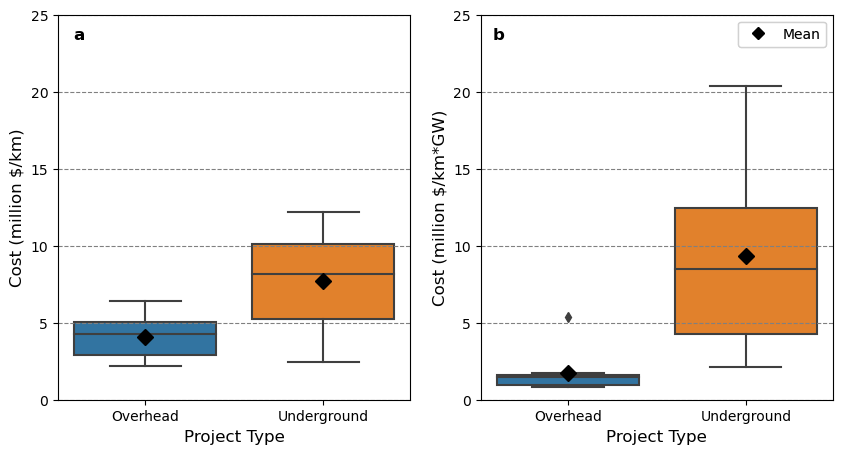

In [264]:
# Generate Figure 3

fig, ax = plt.subplots(1, 2,figsize=(10, 5))
sns.boxplot(  y="cpki", x= "route", data=USAp.drop(3),  orient='v' , ax=ax[0],order=order2)
sns.boxplot(  y="cpkei", x= "route", data=USAp.drop(3),  orient='v' , ax=ax[1],order=order2)

ax[0].plot(order2[0],OH_live.cpki.mean(), linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k", zorder = 4)
ax[0].plot(order2[1], UG_live.drop(3).cpki.mean(), linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k", zorder = 4)

ax[1].plot(order2[0],OH_live.cpkei.mean(), linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k", zorder = 4)
ax[1].plot(order2[1], UG_live.drop(3).cpkei.mean(), linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k", zorder = 4)

# ax[0].set(xlim=(0, 14))
ax[0].set(ylim=(0, 25))
ax[1].set(ylim=(0, 25))
ax[0].set_ylabel('Cost (million $/km)', fontsize=12)
ax[1].set_ylabel('Cost (million $/km*GW)', fontsize=12)
ax[0].set_xlabel('Project Type',fontsize=12)
ax[1].set_xlabel('Project Type',fontsize=12)
# fig.text(0.5, 0.04, 'Project ', fontsize = 12, va='center')#, rotation='vertical')
ax[0].yaxis.grid(color='gray', linestyle='dashed')
ax[1].yaxis.grid(color='gray', linestyle='dashed')
purple= mlines.Line2D([], [], color='k', marker='D', linestyle='None',
                            markersize=6, label='Mean')
legend = plt.legend(handles=[purple], bbox_to_anchor=(1, 1))
# ax[0].add_artist(legend)
ax[1].add_artist(legend)
fig.text(0.56, 0.84, 'b', fontsize = 12, va='center',weight='bold')#, rotation='vertical')
fig.text(0.14, 0.84, 'a', fontsize = 12, va='center',weight='bold')
ax[0].set_xticklabels(['Overhead', 'Underground'])
ax[1].set_xticklabels(['Overhead', 'Underground'])

[Text(0, 0, 'Overhead'), Text(1, 0, 'Underwater'), Text(2, 0, 'Underground')]

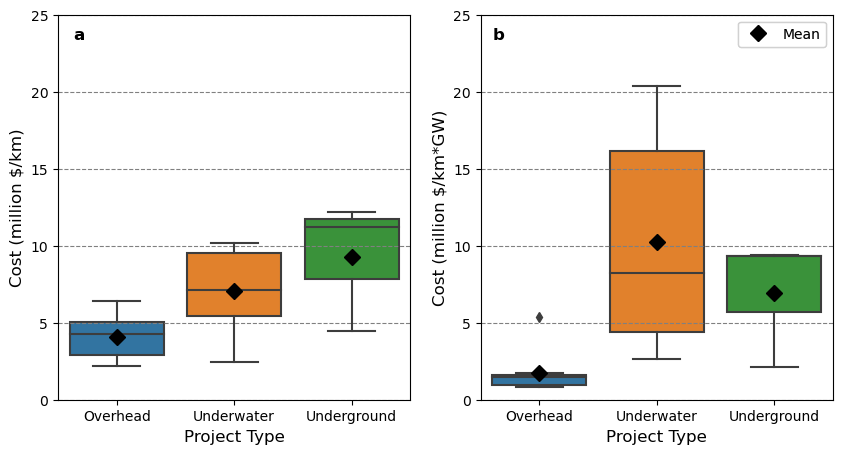

In [265]:
# Generate Supplement Figure 3

fig, ax = plt.subplots(1, 2,figsize=(10, 5))
sns.boxplot(  y="cpki", x= "cable_loc", data=USAp.drop(3),  orient='v' , ax=ax[0],order=order)
sns.boxplot(  y="cpkei", x= "cable_loc", data=USAp.drop(3),  orient='v' , ax=ax[1],order=order)

ax[0].plot(order[0],OH_live.cpki.mean(), linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k", zorder = 4)
ax[0].plot(order[1], uguw.drop(3).cpki.mean(), linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k", zorder = 4)
ax[0].plot(order[2], ugg.cpki.mean(), linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k", zorder = 4)

ax[1].plot(order[0],OH_live.cpkei.mean(), linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k", zorder = 4)
ax[1].plot(order[1], uguw.drop(3).cpkei.mean(), linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k", zorder = 4)
ax[1].plot(order[2], ugg.cpkei.mean(), linestyle="", markersize=8,\
         marker="D", color= 'k', markeredgecolor="k", zorder = 4)

# ax[0].set(xlim=(0, 14))
ax[0].set(ylim=(0, 25))
ax[1].set(ylim=(0, 25))
ax[0].set_ylabel('Cost (million $/km)', fontsize=12)
ax[1].set_ylabel('Cost (million $/km*GW)', fontsize=12)
ax[0].set_xlabel('Project Type',fontsize=12)
ax[1].set_xlabel('Project Type',fontsize=12)
# fig.text(0.5, 0.04, 'Project ', fontsize = 12, va='center')#, rotation='vertical')
ax[0].yaxis.grid(color='gray', linestyle='dashed')
ax[1].yaxis.grid(color='gray', linestyle='dashed')
purple= mlines.Line2D([], [], color='k', marker='D', linestyle='None',
                            markersize=8, label='Mean')
legend = plt.legend(handles=[purple], bbox_to_anchor=(1, 1))
# ax[0].add_artist(legend)
ax[1].add_artist(legend)
fig.text(0.56, 0.84, 'b', fontsize = 12, va='center',weight='bold')#, rotation='vertical')
fig.text(0.14, 0.84, 'a', fontsize = 12, va='center',weight='bold')
ax[0].set_xticklabels(['Overhead', 'Underwater', 'Underground'])
ax[1].set_xticklabels(['Overhead', 'Underwater', 'Underground'])

## Generation in Interconnection Queue
Data Source: [Queued Up 2023](https://emp.lbl.gov/publications/queued-characteristics-power-plants-1)

In [278]:
queue = pd.read_excel(r'C:data\queues_2022_clean_data.xlsx', 'data')

In [279]:
qa = queue[queue.q_status == 'active']

In [280]:
vre_type = np.array(['Solar', 'Solar+Battery', 'Wind',
       'Hydro', 'Geothermal',
        'Solar+Wind+Battery', 'Nuclear',
        'Wind+Battery', 'Solar+Wind',
       'Offshore Wind+Battery', 'Offshore Wind',
       'Other+Solar'])

solar = np.array(['Solar', 'Solar+Battery',
        'Solar+Wind+Battery', 'Solar+Wind',
       'Other+Solar'])

wind = np.array(['Wind',
        'Solar+Wind+Battery', 
        'Wind+Battery', 'Solar+Wind',
       'Offshore Wind+Battery', 'Offshore Wind']) 

In [281]:
# qa.type_clean.unique()

In [282]:
qa.type_clean.unique()
qa[qa.type_clean.isin(vre_type)].mw1.sum()
qavre = qa[qa.type_clean.isin(vre_type)].reset_index(drop=True)

In [283]:
qavre['region'] = qavre['region'].str.replace('-',' ') 

In [349]:
qavre['state'] = qavre['state'].str.strip()


In [350]:
qavre.type1.unique()

array(['Solar', 'Wind', 'Hydro', 'Geothermal', nan, 'Nuclear',
       'Offshore Wind', 'Other', 'Pumped Storage'], dtype=object)

In [353]:
(qavre.groupby('type1').sum()).sum()
#1242 GW of zero-carbon energy in queue

q_year       15196947.00
prop_year    14703453.00
mw1           1241572.87
mw2            147286.80
mw3              3364.00
dtype: float64

## Figure 1: GIS Map HVDC Projects and Renewable Resource Zones
Data Sources for Figure 1: 
* Operational HVDC Transmission Lines - [Homeland Infrastructure Foundation-Level Data (HIFLD)](https://hifld-geoplatform.opendata.arcgis.com/datasets/independent-system-operators-1/explore?location=31.109632%2C-95.679925%2C3.94)
* Zero-Carbon Resource Zone GIS data - [National Renewable Energy Laboratory GIS](https://www.nrel.gov/gis/data-tools.html)
* HVDC Project Routes - Located at Zenodo DOI
* U.S. State Boundaries - [ARrcGIS hub](https://hub.arcgis.com/datasets/1612d351695b467eba75fdf82c10884f/explore?location=35.486521%2C-71.878598%2C3.98)


In [124]:
#Dependencies
import pandas as pd
import geopandas as gpd
# import geoplot as gplt

from pathlib import Path
import matplotlib.colors as colors
import os

import numpy as np

import matplotlib.lines as mlines
import matplotlib.pyplot as plt

import rioxarray # for the extension to load
import xarray
import rasterio as rio

%matplotlib inline

In [372]:
#Load in NREL wind and solar .tif files

fp = r'C:data\Figure_3\wtk_conus_100m_mean_masked.tif'
fp2 = r'C:data\Figure_3\nsrdb3_ghi.tif'
# Open the file:
raster = rasterio.open(fp)

# Check type of the variable 'raster'
# type(raster)

In [356]:
# gdf[gdf.wind_speed > 8].plot(column = 'wind_speed', legend =True)
# plt.gca().invert_yaxis()

In [357]:
#Open arrays and make available for manipulation

rds = rioxarray.open_rasterio(fp,default_name = 'wind_speed')
rds_4326 = rds.rio.reproject("EPSG:4326")
df = rds_4326[0].to_pandas()

rds2 = rioxarray.open_rasterio(fp2,default_name = 'solar')
rds_4326s = rds2.rio.reproject("EPSG:4326")

ra = rio.open(fp)
bounds  = ra.bounds

In [358]:
bounds

BoundingBox(left=-2577339.0, bottom=1236759.0, right=2368072.0, top=-1615898.0)

In [359]:
# rds_4326s.where(rds_4326s.values>4.5).plot()

In [360]:
rds_4326s

<xarray.DataArray 'solar' (band: 1, y: 2025, x: 3940)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * x            (x) float64 -180.0 -179.9 -179.9 -179.9 ... -22.5 -22.46 -22.42
  * y            (y) float64 59.97 59.93 59.89 59.85 ... -20.91 -20.95 -20.99
  * band         (band) int32 1
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     0.0

In [361]:
# Align solar and wind indices for plotting
rr = rds_4326s.reindex_like(rds_4326, method='nearest')
giss = rr.where(rds_4326)

# giss.where(giss>4.5).plot()

In [362]:
#Match to resource zone delineation follows NREL maps available at www.nrel.gov/gis

gisw = rds_4326.where(rds_4326.values>6.5) 
giss2 = giss.where(giss.values>4)
gissw = gisw.where(giss2)
x, y, band = gisw.indexes.values()
gissw = giss2.interp(x=x, y=y, method="nearest")
# gissw.plot()

In [363]:
# Shared resource zone (ie, wind +solar)
gisswn= giss2-gisw
# gisswn.plot()

In [365]:
# Load in relevant boundaries
usstates = gpd.read_file(r'C:data\Figure_3\US_State_Boundaries\US_State_Boundaries.shp')

tx_lines = gpd.read_file(r'C:data\Figure_3\Electric__Power_Transmission_Lines.geojson')
tx_lines2 = gpd.read_file(r'C:data\Figure_3\U.S._Electric_Power_Transmission_Lines.geojson')

In [366]:
# Open HVDC geometries generated in ArcMap
hvdc_route = gpd.read_file(r'C:data\Figure_3\hvdc_routes\hvdc_routes.shp')

<Axes: >

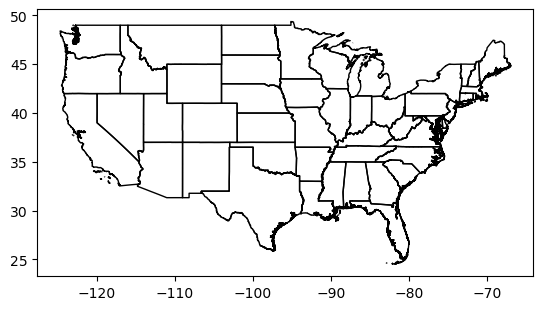

In [367]:
contstates = usstates[(usstates.NAME != ('Alaska')) & (usstates.NAME != ('Hawaii'))& (usstates.NAME != ('Puerto Rico'))& (usstates.NAME != ('U.S. Virgin Islands'))]
contstates.plot(color = 'none', edgecolor = 'black')

In [368]:
hvdc_route.head()

,Id,NAME,TIMELINE,geometry
0,1,Champlain Hudson Power Express,Planned,"LINESTRING Z (-73.35338 45.02484 0.00000, -73...."
1,2,Cross Sound Cable,Operation,"LINESTRING Z (-72.90444 41.29573 0.00000, -72...."
2,3,Hudson Transmission,Operation,"LINESTRING Z (-73.99595 40.77023 0.00000, -73...."
3,4,Neptune Cable,Operation,"LINESTRING Z (-73.55089 40.79690 0.00000, -73...."
4,5,New England Clean Energy Connect,Planned,"LINESTRING Z (-70.28880 44.14847 0.00000, -70...."


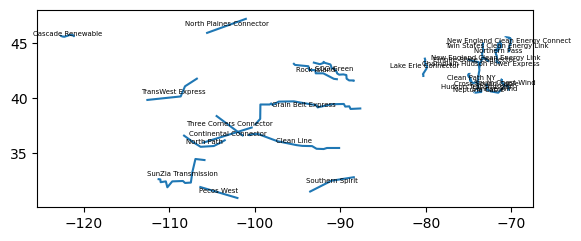

In [369]:
# Rough look at hvdc_route
# ax = hvdc_route.plot()
hvdc_route['coords'] =  hvdc_route['geometry'].apply(lambda x: x.representative_point().coords[:])
hvdc_route['coords'] = [coords[0] for coords in  hvdc_route['coords']]
# hvdc_route.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
# hvdc_route.head()
# hvdc_route.plot()
# for idx, row in hvdc_route.iterrows():
#     plt.annotate(s=row['NAME'], xy=row['coords'],
#                  horizontalalignment='center')
points_gdf = hvdc_route.copy()
points_gdf['geometry'] = points_gdf['geometry'].apply(lambda line: line.coords[0])

ax = hvdc_route.plot()
hvdc_route.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center', fontsize =5), axis=1);

In [370]:
points_gdf

,Id,NAME,TIMELINE,geometry,coords
0,1,Champlain Hudson Power Express,Planned,"(-73.35338105381572, 45.024838426812835, 0.0)","(-73.67698775060865, 43.04512686996202, 0.0)"
1,2,Cross Sound Cable,Operation,"(-72.90443752408021, 41.29572672984324, 0.0)","(-72.90189467886006, 41.14872335653422, 0.0)"
2,3,Hudson Transmission,Operation,"(-73.99594595008745, 40.77022560259405, 0.0)","(-73.99539070725734, 40.81186881485547, 0.0)"
3,4,Neptune Cable,Operation,"(-73.55088628317299, 40.796898552377286, 0.0)","(-73.8330015870419, 40.520482547576364, 0.0)"
4,5,New England Clean Energy Connect,Planned,"(-70.28880325694251, 44.14846865048628, 0.0)","(-70.1124528915754, 45.1007606234686, 0.0)"
5,6,Twin States Clean Energy Link,Planned,"(-71.51608172723058, 45.010626336188125, 0.0)","(-71.55177364231804, 44.61087688720863, 0.0)"
6,7,Northern Pass,Cancelled,"(-71.4232827480032, 45.13911723050296, 0.0)","(-71.55891202533553, 44.25395773633409, 0.0)"
7,8,New England Clean Energy Link,Cancelled,"(-73.38193458588569, 43.711375951594505, 0.0)","(-72.97231186279873, 43.540119434584994, 0.0)"
8,9,Empire State Connector,Planned,"(-73.78168403486518, 42.75007370523906, 0.0)","(-74.4927874455243, 43.34024471009525, 0.0)"
9,10,Clean Path NY,Planned,"(-73.93299734872153, 41.35630738074309, 0.0)","(-74.74976923415397, 41.691278233054845, 0.0)"


Text(656.9722222222223, 0.5, ' ')

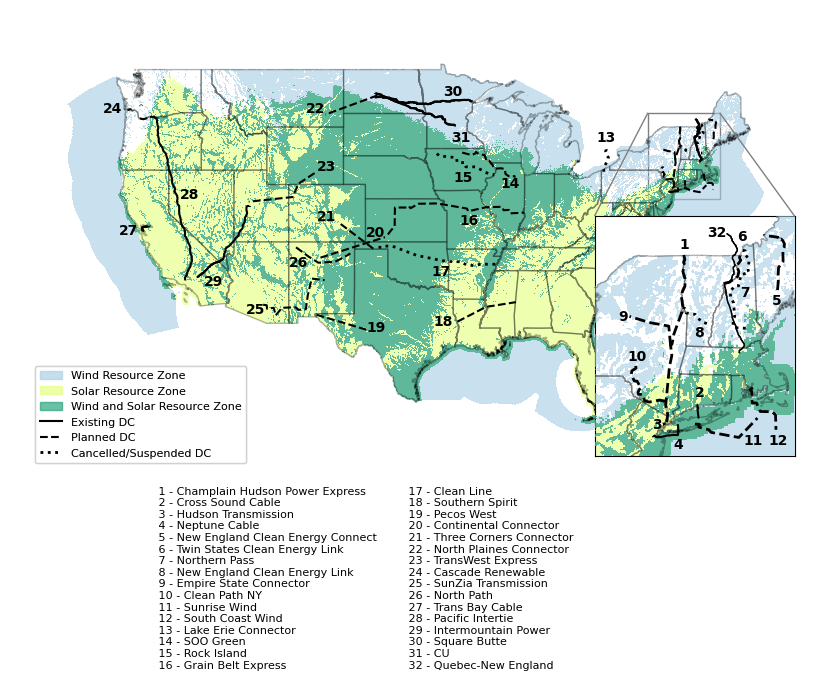

In [371]:
#Generate Figure 1

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax = plt.subplots(figsize=(10, 6))

#Renewable Resource Zones
rds_4326.where(rds_4326.values>6.5).plot(levels = [6.5,20],cmap = 'Paired',add_colorbar=False, alpha = 0.6, zorder = 3)
giss.where(giss.values>4).plot(levels = [7,20],cmap = 'Wistia',add_colorbar=False, alpha = 0.6, zorder = 2)
gisswn.plot(levels = [7,20],cmap = 'Dark2',add_colorbar=False, alpha = 0.6,zorder = 4)

#State Boundaries
contstates.plot(color = 'none', edgecolor = 'black', zorder =5, ax=ax, alpha = 0.3)

#HVDC Lines
tx_lines[tx_lines.TYPE.str.contains("DC")].plot(column = 'tag', color = 'k', zorder =6, ax=ax)
tx_lines2[tx_lines2.TYPE.str.contains("DC")].plot(column = 'tag', color = 'k', zorder =6, ax=ax, legend = 'True')

hvdc_route[hvdc_route.TIMELINE == 'Operation'].plot(color='k', zorder =7, ax=ax)
hvdc_route[hvdc_route.TIMELINE == 'Planned'].plot(color='k',linestyle='--', zorder =7, ax=ax)
hvdc_route[(hvdc_route.TIMELINE == 'Cancelled')|(hvdc_route.TIMELINE == 'Suspended')].plot(color='k',linestyle=':',linewidth = 2,zorder =7, ax=ax)


label_list = [f" {row['Id']} - {row['NAME']}" for idx, row in hvdc_route.iterrows()]
label_list2 = [' 27 - Trans Bay Cable', ' 28 - Pacific Intertie', ' 29 - Intermountain Power', ' 30 - Square Butte',' 31 - CU',' 32 - Quebec-New England']
label_list3 = label_list + label_list2

midpoint = len(label_list3) // 2

plt.figtext(0.25, 0.1, '\n'.join(label_list3[:midpoint]), ha = 'left', va = 'top', fontsize =8)
plt.figtext(0.5, 0.1, '\n'.join(label_list3[midpoint:]), ha = 'left', va = 'top', fontsize =8)


blue = mpatches.Patch(color= '#a6cee3', alpha = 0.6, label='Wind Resource Zone')
cyan = mpatches.Patch(color='#e4ff7a', alpha = 0.6,  label='Solar Resource Zone')
green = mpatches.Patch(color='#1b9e77',  alpha = 0.6,label='Wind and Solar Resource Zone')
black_line = mlines.Line2D([], [], color='black', #marker='*',
                          markersize=15, label='Existing DC')
grey_line = mlines.Line2D([], [], color='black',  linestyle='--', #marker='*',
                          markersize=15, label='Planned DC')
g_line = mlines.Line2D([], [], color='black',  linestyle=':', #marker='*',
                          linewidth=2, label='Cancelled/Suspended DC')
legend = plt.legend(handles=[blue,cyan,green,black_line, grey_line, g_line], loc =3,fontsize=8)
ax.add_artist(legend)
#remove axis ticks
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.title(' ')
plt.xlabel(' ')
plt.ylabel(' ')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)



# second inset plot
left, bottom, width, height = [0.69, 0.15, 0.2, 0.4]
axins = plt.axes([left, bottom, width, height])
# axins.set_xlim(target_line.bounds[0], target_line.bounds[2])
# axins.set_ylim(target_line.bounds[1], target_line.bounds[3])
axins.set_xlim(-76, -70)
axins.set_ylim(34, 52)
axins.set_aspect('equal', adjustable='datalim')

# hvdc_route.plot(linewidth=2, color= 'black', ax=axins)
#HVDC Lines
hvdc_route[hvdc_route.TIMELINE == 'Operation'].plot(color='k', ax=axins,zorder=5)
hvdc_route[hvdc_route.TIMELINE == 'Planned'].plot(color='k',linestyle='--',linewidth = 2, ax=axins,zorder=5)
hvdc_route[(hvdc_route.TIMELINE == 'Cancelled')|(hvdc_route.TIMELINE == 'Suspended')].plot(color='k',linestyle=':',linewidth = 2, ax=axins,zorder=5)
contstates.plot(color = 'none', edgecolor = 'black', zorder =5, ax=axins, alpha = 0.3)
tx_lines[tx_lines.TYPE.str.contains("DC")].plot(column = 'tag', color = 'k',linewidth = 1, ax=axins, zorder=5)
tx_lines2[tx_lines2.TYPE.str.contains("DC")].plot(column = 'tag', color = 'k', linewidth = 1, ax=axins, legend = 'True')

# Renewable Resource Zones
rds_4326.where(rds_4326.values>6.5).plot(levels = [6.5,20],cmap = 'Paired',add_colorbar=False,ax=axins, alpha = 0.6, zorder = 3)
giss.where(giss.values>4).plot(levels = [7,20],cmap = 'Wistia',add_colorbar=False,ax=axins, alpha = 0.6, zorder = 2)
gisswn.plot(levels = [7,20],cmap = 'Dark2',add_colorbar=False,ax=axins, alpha = 0.6,zorder = 4)

axins.set_xlim(-76,-70)
axins.set_ylim(40,46)

mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")
# # mark_inset(ax, axins2, loc1=2, loc2=3, fc="none", ec="0.5")

#annotate
axins.annotate('1', xy=(-73.5, 45.2), weight = "bold", zorder = 8)
axins.annotate('2', xy=(-73, 41.5), weight = "bold", zorder = 8)
axins.annotate('3', xy=(-74.4, 40.7), weight = "bold", zorder = 8)
axins.annotate('4', xy=(-73.7, 40.2), weight = "bold", zorder = 8)
axins.annotate('5', xy=(-70.46, 43.8), weight = "bold", zorder = 8)
axins.annotate('6', xy=(-71.6, 45.4), weight = "bold", zorder = 8)
axins.annotate('7', xy=(-71.5, 44), weight = "bold", zorder = 8)
axins.annotate('8', xy=(-73, 43), weight = "bold", zorder = 8)
axins.annotate('9', xy=(-75.5, 43.4), weight = "bold", zorder = 8)
axins.annotate('10', xy=(-75.2, 42.4), weight = "bold", zorder = 8)
axins.annotate('11', xy=(-71.4, 40.3), weight = "bold", zorder = 8)
axins.annotate('12', xy=(-70.6, 40.3), weight = "bold", zorder = 8)
axins.annotate('32', xy=(-72.6, 45.5), weight = "bold", zorder = 8)
ax.annotate('13', xy=(-81, 44), weight = "bold", zorder = 8)
ax.annotate('14', xy=(-89.7, 40.8), weight = "bold", zorder = 8)
ax.annotate('15', xy=(-94, 41.2), weight = "bold", zorder = 8)
ax.annotate('16', xy=(-93.5, 38.2), weight = "bold", zorder = 8)
ax.annotate('17', xy=(-96, 34.7), weight = "bold", zorder = 8)
ax.annotate('18', xy=(-95.8, 31.2), weight = "bold", zorder = 8)
ax.annotate('19', xy=(-102, 30.8), weight = "bold", zorder = 8)
ax.annotate('20', xy=(-102, 37.4), weight = "bold", zorder = 8)
ax.annotate('21', xy=(-106.5, 38.5), weight = "bold", zorder = 8)
ax.annotate('22', xy=(-107.5, 46), weight = "bold", zorder = 8)
ax.annotate('23', xy=(-106.5, 42), weight = "bold", zorder = 8)
ax.annotate('24', xy=(-126, 46), weight = "bold", zorder = 8)
ax.annotate('25', xy=(-113, 32), weight = "bold", zorder = 8)
ax.annotate('26', xy=(-109, 35.3), weight = "bold", zorder = 8)
ax.annotate('27', xy=(-124.5, 37.5), weight = "bold", zorder = 8)
ax.annotate('28', xy=(-119, 40), weight = "bold", zorder = 8)
ax.annotate('29', xy=(-116.8, 34), weight = "bold", zorder = 8)
ax.annotate('30', xy=(-95, 47.2), weight = "bold", zorder = 8)
ax.annotate('31', xy=(-94.2, 44), weight = "bold", zorder = 8)

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.title(' ')
plt.xlabel(' ')
plt.ylabel(' ')

### Exploratory Regional Analysis and Converter Station Costs
Not in Manuscript. Used for data exploration. \
WARNING Assumptions made regarding technology and cost.

In [266]:
regions = hvdc.groupby(by = 'region').mean().reset_index()
regions

,region,index,SY,CY,FPY,IPY,PY,IDY,Overall_time (years),length_mile,...,length_km,cpm,cpme,cpmi,cpmei,cpk,cpke,cpki,cpkei,cost_adjusted
0,CAISO,6.0,2010.000000,2007.000000,2007.00,2004.0,2004.0,2004.000000,6.0,53.000000,...,85.295020,8.301887,20.754717,13.111057,32.777641,5.158566,12.896415,8.146853,20.367133,694.885997
1,ERCOT,25.0,2029.000000,NaN,2024.00,NaN,2020.0,2020.000000,9.0,280.000000,...,450.615200,3.571429,2.380952,3.571429,2.380952,2.219188,1.479459,2.219188,1.479459,1000.000000
2,ERCOT - MISO,29.0,2028.000000,2025.000000,NaN,2014.0,2010.0,2010.000000,18.0,320.000000,...,514.988800,7.812500,2.604167,7.812500,2.604167,4.854475,1.618158,4.854475,1.618158,2500.000000
3,ISO NE,10.0,2020.666667,2016.333333,2015.80,2012.2,2013.5,2012.666667,8.0,113.666667,...,182.928313,10.071684,10.596458,11.830955,13.823628,6.258270,6.584350,7.351433,8.589626,1384.417719
4,MISO,17.0,2023.000000,NaN,2019.50,2017.5,2016.0,2016.000000,7.0,443.000000,...,712.937620,6.145078,1.953121,6.831823,2.149334,3.818384,1.213616,4.245108,1.335538,2943.372510
5,MISO - PJM,1.0,2027.000000,NaN,2023.00,2020.0,2019.0,2015.000000,12.0,350.000000,...,563.269000,7.142857,3.401361,7.142857,3.401361,4.438377,2.113513,4.438377,2.113513,2500.000000
6,NYISO,15.6,2023.200000,2020.600000,2019.75,2015.0,2013.4,2013.400000,9.8,188.700000,...,303.682458,32.297535,42.113739,41.152086,55.475630,20.068808,26.168329,25.570784,34.471044,2710.591940
7,NYISO - PJM,7.0,2007.000000,2005.000000,2004.00,2002.0,2001.0,2001.000000,6.0,65.000000,...,104.607100,9.230769,13.986014,16.401131,24.850199,5.735748,8.690528,10.191216,15.441236,1066.073527
8,Northwest,18.0,2028.000000,2023.000000,2017.00,2017.0,2014.0,2012.500000,15.5,252.500000,...,406.358350,11.203704,8.052750,11.203704,8.052750,6.961676,5.003759,6.961676,5.003759,2250.000000
9,PJM,31.0,2022.000000,NaN,2021.00,2014.0,2014.0,2013.000000,9.0,73.000000,...,117.481820,13.698630,13.698630,13.698630,13.698630,8.511955,8.511955,8.511955,8.511955,1000.000000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


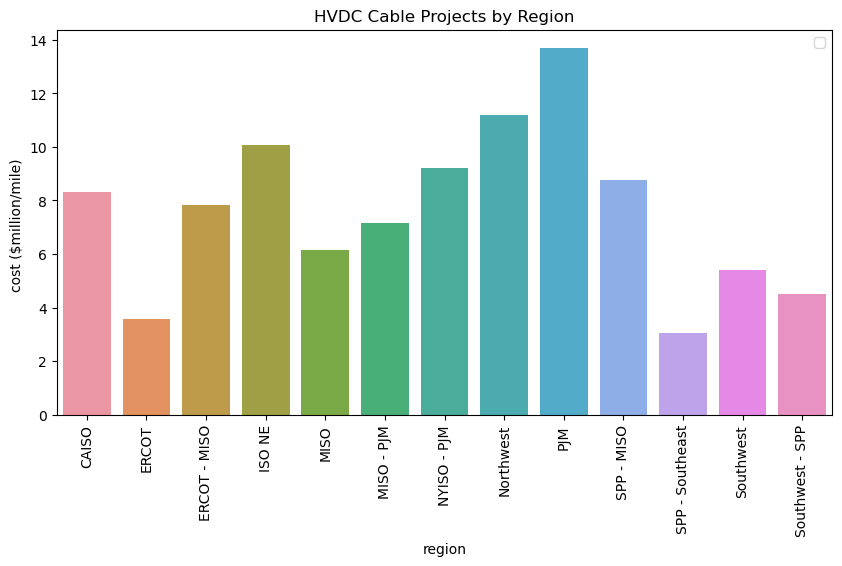

In [267]:
# Generate figure of projects by region
fig, ax = plt.subplots(figsize=(10, 5))
ax1 = sns.barplot(x = 'region', y="cpm", data=regions.drop([6]))
# ax.set(ylim=(0, 20))
ax.set_ylabel('cost ($million/mile) ')
ax.set_title('HVDC Cable Projects by Region')
# ax.set_xticks(ind)
# ax.set_xticklabels(UG.project)
plt.xticks(rotation=90)
ax.legend()


In [268]:
#Generate DataFrames of Project Timeline Stages

usadev = USA.IDY.value_counts().reset_index().rename(columns={'index': 'year'})

usaprop= USA.PY.value_counts().reset_index().rename(columns={'index': 'year'})

usaser = USA.SY.value_counts().reset_index().rename(columns={'index': 'year'})
# usamil = USA.drop(29).length_miles.value_counts().reset_index().rename(columns={'index': 'year'})
usanumyrs = pd.concat([usaprop, usaser])
tidy = usanumyrs.melt(id_vars='year').rename(columns=str.title)


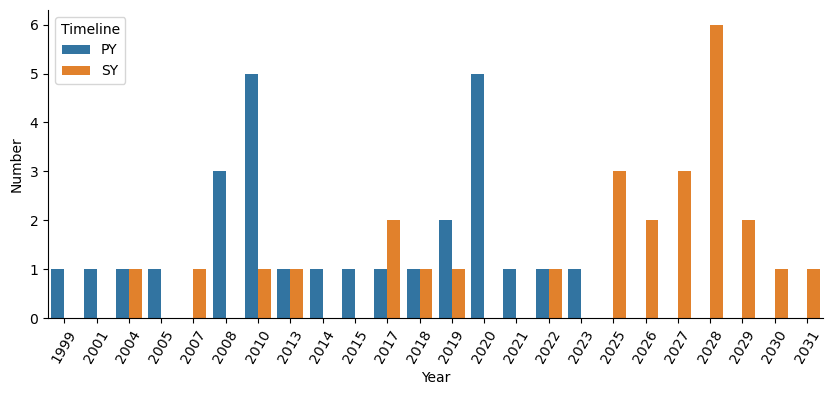

In [269]:
# Generate figure of project timeline by first and final stages

USA_dev = USA.groupby(by = ['PY','SY']).sum(numeric_only=True)

fig, ax = plt.subplots(figsize=(10, 4))
# tidy = df.melt(id_vars='labels').rename(columns=str.title)
sns.barplot(x=tidy.Year.astype(int), y='Value', hue='Variable', data=tidy, ax=ax)
sns.despine(fig)
ax.tick_params(axis='x', labelrotation=60)
sns.despine(fig)
plt.legend(title='Timeline', loc='upper left')
ax.set_ylabel('Number')
ax.set_xlabel('Year')
plt.show()

# usanumyrs.plot(x="year", y=["IDY", "SY"], kind="bar")

Text(0, 0.5, 'Length(km)')

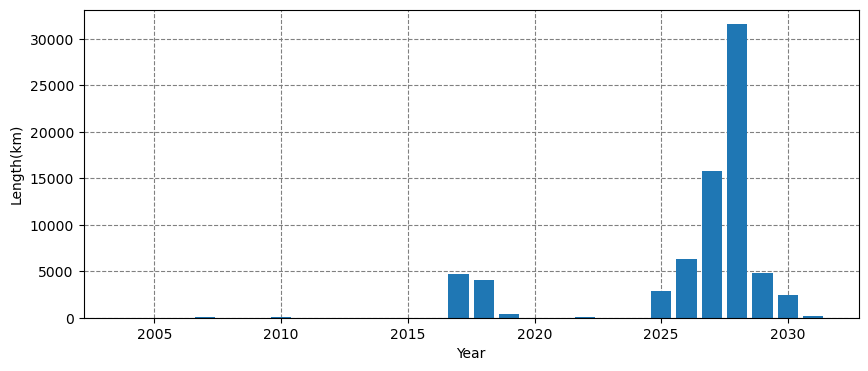

In [270]:
# Generate figure of project proposed/actual service versus project length

import matplotlib.ticker as plticker

fig, ax = plt.subplots(figsize=(10, 4))
usalm  = USA.groupby(by = 'SY').sum(numeric_only=True).reset_index()
ax.bar(usalm.SY,usalm.length_km*(usalm.power_rating_MW/1000))
# loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
# ax.xaxis.set_major_locator(loc)
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_xlabel('Year')
ax.set_ylabel('Length(km)')

In [271]:
usalm[usalm.SY>=2025]

,SY,index,CY,FPY,IPY,PY,IDY,Overall_time (years),length_mile,cost_million,...,length_km,cpm,cpme,cpmi,cpmei,cpk,cpke,cpki,cpkei,cost_adjusted
8,2025,56,6067.0,4042.0,6054.0,6050.0,6050.0,25.0,531.0,4300,...,854.55954,22.707216,19.443662,23.332010,20.119846,14.109645,12.081762,14.497875,12.501923,4375.6
9,2026,22,4045.0,4045.0,4030.0,4016.0,4016.0,36.0,922.0,8500,...,1483.81148,20.674487,14.418377,20.674487,14.418377,12.846562,8.959187,12.846562,8.959187,8500.0
10,2027,43,4048.0,6071.0,6055.0,6050.0,6046.0,35.0,1328.0,13000,...,2137.20352,35.555778,20.714185,35.555778,20.714185,22.093391,12.871230,22.093391,12.871230,13000.0
11,2028,140,6073.0,8091.0,10092.0,12097.0,12094.0,74.0,1595.0,11550,...,2566.89730,49.327050,26.819785,49.327050,26.819785,30.650484,16.665083,30.650484,16.665083,11550.0
12,2029,44,0.0,4049.0,2023.0,4042.0,4042.0,16.0,666.0,4200,...,1071.82044,11.861584,5.144338,11.861584,5.144338,7.370465,3.196551,7.370465,3.196551,4200.0
13,2030,26,0.0,2025.0,0.0,2020.0,2020.0,10.0,500.0,2000,...,804.67000,4.000000,1.333333,4.000000,1.333333,2.485491,0.828497,2.485491,0.828497,2000.0
14,2031,10,2026.0,0.0,0.0,2023.0,2023.0,8.0,101.0,1820,...,162.54334,18.019802,15.016502,18.019802,15.016502,11.197014,9.330845,11.197014,9.330845,1820.0


In [272]:
import matplotlib.ticker as plticker

loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)

In [273]:
# plt.bar(USA.sort_values(by = "SY").SY.astype(int),USA.sort_values(by = "SY").length_mile)

In [313]:
# Converter station costs from MISO Transmission cost estimation guide - exploratory VSC costs (2023)
project_type = [OH_live, ugg, uguw.drop([2,3]), UG_live.drop([2,3])]
#undeground not including Hudson Tx (cost effect) and Cross sound cable (voltage effect) as they sway the converter station mean to either extreme
type_converter_costs = np.array([])
# for type in project_type:
pt = 0 # adjust for type ie, [0 = Overhead, 1 = terrestrial underground, 2 = underwater, 3 = all underground]
for i in project_type[pt].voltage_rating_kV: 
    if i >= 550:
        converter_costs =  (i/575)*715
    if i<550 & i>= 500:
        converter_costs =  (i/525)*591
    elif i<500 & i>=300:
        converter_costs =  (i/400)*440
    else:
        converter_costs =  (i/250)*152
    type_converter_costs = np.append(type_converter_costs, converter_costs)
  

print('Average cost of 1 converter station for this project location type =', round(type_converter_costs.mean(),2))
# Costs without converter stations
print('Average cost of project - 2 converter stations =', round((project_type[pt].cost_adjusted - type_converter_costs*2).mean(),2))

Average cost of 1 converter station for this project location type = 308.26
Average cost of project - 2 converter stations = 2053.49


In [312]:
# from NREL https://www.nrel.gov/docs/fy23osti/87184.pdf converter station cost curve $142.61 / kw Härtel et al. 2017; Pletka et al. 2014; MISO 2020
#converter station costs for OH lines
# ((OH_live.power_rating_MW*1000 * 142.61)/1e6)#.mean()

## END